In [1]:
import numpy as np
import json
import pandas as pd
from k_means_constrained import KMeansConstrained
import seaborn as sns
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import itertools
from itertools import chain
from datetime import datetime
import math

In [2]:
# load the JSON file
with open("route_data.json") as f:
    route = json.load(f)

# count the number of keys
num_routes = len(route.keys())

print(f"The JSON file has {num_routes} routes.")

The JSON file has 6112 routes.


In [3]:
routedf=pd.DataFrame(route)
routedf=routedf.T
routedf.head()

,station_code,date_YYYY_MM_DD,departure_time_utc,executor_capacity_cm3,route_score,stops
RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,DLA3,2018-07-27,16:02:10,3313071.0,High,"{'AD': {'lat': 34.099611, 'lng': -118.283062, ..."
RouteID_0016bc70-cb8d-48b0-aa55-8ee50bdcdb59,DSE4,2018-07-28,15:44:41,4247527.0,High,"{'AC': {'lat': 47.689446, 'lng': -122.296071, ..."
RouteID_001948e9-4675-486d-9ec5-912fd8e0770f,DSE5,2018-08-18,15:32:04,4247527.0,High,"{'AA': {'lat': 47.268001, 'lng': -122.5079, 't..."
RouteID_001b4ee3-c4f2-467f-932b-c85524d1021f,DLA9,2018-08-15,15:09:38,3313071.0,High,"{'AB': {'lat': 33.823076, 'lng': -118.058727, ..."
RouteID_0021a2aa-780f-460d-b09a-f301709e2523,DLA7,2018-08-05,14:23:26,3313071.0,High,"{'AA': {'lat': 33.84364, 'lng': -117.773651, '..."


In [4]:
# load the JSON file
with open("travel_times.json") as f:
    travel= json.load(f)

# count the number of keys
num_travels = len(travel.keys())

print(f"The JSON file has {num_travels} .")


The JSON file has 6112 .


In [5]:
traveldf=pd.DataFrame(travel)
traveldf=traveldf.T
traveldf.head()

,AD,AF,AG,BA,BE,BG,BP,BT,BY,BZ,...,GG,PH,EN,QN,SG,SX,SU,UK,VK,BN
RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,"{'AD': 0.0, 'AF': 198.3, 'AG': 264.9, 'BA': 26...","{'AD': 209.8, 'AF': 0.0, 'AG': 348.3, 'BA': 22...","{'AD': 295.7, 'AF': 333.6, 'AG': 0.0, 'BA': 27...","{'AD': 284.0, 'AF': 219.5, 'AG': 288.2, 'BA': ...","{'AD': 107.9, 'AF': 178.9, 'AG': 308.2, 'BA': ...","{'AD': 136.3, 'AF': 90.6, 'AG': 264.2, 'BA': 2...","{'AD': 120.0, 'AF': 267.6, 'AG': 163.7, 'BA': ...","{'AD': 172.7, 'AF': 64.8, 'AG': 317.3, 'BA': 2...","{'AD': 251.3, 'AF': 341.9, 'AG': 82.8, 'BA': 2...","{'AD': 58.8, 'AF': 240.8, 'AG': 279.1, 'BA': 2...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RouteID_0016bc70-cb8d-48b0-aa55-8ee50bdcdb59,NaN,NaN,"{'AC': 426.5, 'AE': 295.1, 'AG': 0.0, 'AN': 12...","{'AC': 321.3, 'AE': 140.3, 'AG': 330.5, 'AN': ...",NaN,NaN,"{'AC': 216.7, 'AE': 49.6, 'AG': 377.2, 'AN': 3...",NaN,"{'AC': 80.1, 'AE': 102.1, 'AG': 311.7, 'AN': 3...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RouteID_001948e9-4675-486d-9ec5-912fd8e0770f,"{'AA': 244.7, 'AD': 0.0, 'AJ': 434.0, 'AP': 17...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RouteID_001b4ee3-c4f2-467f-932b-c85524d1021f,NaN,NaN,"{'AB': 290.8, 'AC': 69.8, 'AG': 0.0, 'AI': 310...",NaN,"{'AB': 230.4, 'AC': 265.4, 'AG': 319.1, 'AI': ...",NaN,NaN,NaN,"{'AB': 227.7, 'AC': 359.7, 'AG': 364.3, 'AI': ...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RouteID_0021a2aa-780f-460d-b09a-f301709e2523,NaN,"{'AA': 427.0, 'AB': 529.9, 'AF': 0.0, 'AG': 37...","{'AA': 241.8, 'AB': 334.3, 'AF': 359.1, 'AG': ...",NaN,NaN,"{'AA': 588.2, 'AB': 473.8, 'AF': 264.2, 'AG': ...","{'AA': 529.7, 'AB': 609.7, 'AF': 329.1, 'AG': ...",NaN,NaN,"{'AA': 429.6, 'AB': 515.2, 'AF': 442.5, 'AG': ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# load the JSON file
with open("package_data.json") as f:
    package = json.load(f)

# count the number of keys
num_packages = len(route.keys())

print(f"The JSON file has {num_packages} packages.")

The JSON file has 6112 packages.


In [7]:
def isNaN(string):
    return string != string

def remove_nan(L):
    if L==[]:
        L=[np.nan]
    new_list=[]
    for e in L:
        if isNaN(e)==False:
            new_list.append(e)
    if new_list==[]:
        new_list=[L[0]]
    return new_list

## Fonction pour boucler sur les routes 

In [8]:
def choose_route(number):
    route_distances=pd.DataFrame(traveldf.iloc[number].to_dict()).dropna(axis=1)
    route_stops_data=pd.DataFrame.from_dict(routedf[ 'stops'][number], orient='columns').T
    return route_distances, route_stops_data

def route(number):
    route_distances, route_stops_data=choose_route(number=number)
    X=np.array(route_distances).transpose()
    n_samples=len(X)
    n_clusters=int(len(X)/10)
    #n_clusters=2
    clf = KMeansConstrained(
         n_clusters=n_clusters,
         size_min=int(n_samples/n_clusters)-2,
         size_max=int(n_samples/n_clusters)+1,
         random_state=0
    )
    clf.fit_predict(X)

    route_stops_data["Cluster"]=clf.labels_

    route_stops_data["lat"]=route_stops_data["lat"].astype('float')
    route_stops_data["lng"]=route_stops_data["lng"].astype('float')
    departure_point=route_stops_data[route_stops_data["type"]=="Station"].index[0]
    route_stops_data.at[departure_point,'Cluster']=-1
    route_stops_data["Cluster"]=route_stops_data["Cluster"].astype('category')

    fig, ax = plt.subplots()
    ax.set_xlim(route_stops_data.describe().loc["25%"]["lat"],route_stops_data.describe().loc["75%"]["lat"])
    ax.set_ylim(route_stops_data.describe().loc["25%"]["lng"],route_stops_data.describe().loc["75%"]["lng"])
    sns.scatterplot(data=route_stops_data,x=route_stops_data["lat"], y=route_stops_data["lng"], hue=route_stops_data["Cluster"])

    def get_cluster_points(num_cluster):
        return route_stops_data[route_stops_data["Cluster"]==num_cluster]

    def get_distances_cluster(num_cluster):
        cluster_points_data=get_cluster_points(num_cluster)
        cols=cluster_points_data.index.to_list()
        route_cluster_distances=route_distances[cols]
        route_cluster_distances=route_cluster_distances.loc[cluster_points_data.index]
        distances_list_cluster=[]
        for i in range (route_cluster_distances.shape[0]):
            for j in range (route_cluster_distances.shape[1]):
                if i!=j:
                    row=route_cluster_distances.index[i]
                    column=route_cluster_distances.columns[j]
                    value=route_cluster_distances.loc[row][column]
                    distances_list_cluster.append((row,column,value))
        return distances_list_cluster
    packages_df=pd.DataFrame(package)
    route=packages_df.columns[number]
    packages_route=packages_df[[route]]
    packages_route=packages_route.loc[route_stops_data.index]
    packages_route.head()
    def get_starts_ends():
        start=[]
        end=[]
        starts=[]

        ends=[]
        for i in range (len(packages_route)):
            stop=packages_route.index[i]
            if pd.isna(packages_route.loc[stop][0]):
                continue
            keys=packages_route.loc[stop][0].keys()
            keys=list(keys)
            for k in keys:
                start.append(packages_route.loc[stop][0].get(k).get('time_window').get('start_time_utc'))
                end.append(packages_route.loc[stop][0].get(k).get('time_window').get('end_time_utc'))
            start_cleaned=remove_nan(start)
            end_cleaned=remove_nan(end)
            start_package=min(start_cleaned)
            end_package=max(end_cleaned)
            starts.append((stop,start_package))
            ends.append((stop,end_package))
            start=[]
            end=[]
        return (dict(starts),dict(ends))
    starts,ends=get_starts_ends()


    def get_starts_ends_without_nans(starts,ends):

        non_null=[]

        for element in starts:
            if isNaN(starts[element])==False:
                non_null.append(starts[element])
        min_time=min(non_null)
        non_null=[]
        for element in ends:
            if isNaN(ends[element])==False:
                non_null.append(ends[element])
        max_time=max(non_null)   
        for element in starts:
            if isNaN(starts[element]):
                starts[element]=min_time
        for element in ends:
            if isNaN(ends[element]):
                ends[element]=max_time
        return (starts,ends)

    starts, ends=get_starts_ends_without_nans(starts,ends)
    def get_ab_per_cluster(stop_stations,starts,ends):
        starts_per_cluster=[]
        ends_per_cluster=[]
        for stop in stop_stations:
            date_difference=datetime.strptime(starts[stop], '%Y-%m-%d %H:%M:%S')-origin_time
            days=date_difference.days
            seconds=date_difference.seconds
            total_time=days*24+(seconds/3600)
            starts_per_cluster.append(total_time)
            date_difference=datetime.strptime(ends[stop], '%Y-%m-%d %H:%M:%S')-origin_time
            days=date_difference.days
            seconds=date_difference.seconds
            total_time=days*24+(seconds/3600)
            ends_per_cluster.append(total_time)
        return (starts_per_cluster,ends_per_cluster)

    def apply_algorithm_per_cluster(num_cluster,flag=0):
        
        path= r'C:\Program Files\IBM\ILOG\CPLEX_Studio2211\cplex\bin\x64_win64\cplex.exe'
        G=nx.DiGraph()
        cluster=get_cluster_points(num_cluster=num_cluster)
        stop_stations=list(cluster.index)
        nodes=stop_stations
        edges=get_distances_cluster(num_cluster)
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(edges)
        P=[]
        L=[]
        for i in stop_stations:
            for j in stop_stations:
                if i!=j:
                    L.append(G[i][j]["weight"])
                else:
                    L.append(0)
            P.append(L)
            L=[]
        a,b=get_ab_per_cluster(stop_stations,starts,ends)
        M=(max(b)+max(list(chain.from_iterable(P))))*10
        problem=pulp.LpProblem("Amazon_projet",pulp.LpMinimize)
        X=[[pulp.LpVariable(f"X{i}_{j}", cat=pulp.LpBinary) for j in nodes] for i in nodes]
        t=[pulp.LpVariable(name=f"t{i}",cat=pulp.LpContinuous,lowBound=a[i],upBound=b[i]) for i in range(len(nodes))]
        problem += pulp.lpSum([X[i][j]*P[i][j] for i in range(len(nodes))  for j in range(len(nodes))])
        for i in range(len(nodes)):
            if i != len(nodes)-1:
                problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])==1
            if i!=len(nodes)-1 and i!=0:
                problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) ==pulp.lpSum([X[j][i] for j in range(0, len(nodes))])
            if i==0:
                problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))])-pulp.lpSum([X[j][i] for j in range(0, len(nodes))])==1
            if i==len(nodes)-1:
                problem += pulp.lpSum([X[i][j] for j in range(0, len(nodes))]) - pulp.lpSum([X[j][i] for j in range(0, len(nodes))]) == -1
            problem+=X[i][i]==0
        for j in range(len(nodes)):
            if j!=0:
                problem += pulp.lpSum([X[i][j] for i in range(0, len(nodes))]) == 1
        for i in range(len(nodes)):
            for j in range(len(nodes)):
                t[i]+P[i][j]-t[j]<=M*(1-X[i][j])
        for k in range(len(nodes)):
            for S in range(2, len(nodes)):
                for subset in itertools.combinations([i for i in range(len(nodes)) if i != k], S):
                    problem += pulp.lpSum([X[i][j] for i in subset for j in subset if i != j]) <= len(subset) - 1
        for i in range(len(nodes)):
            for j in range(len(nodes)):
                if pulp.value(X[i][j])==1:
                    edges_selected.append((nodes[i],nodes[j],P[i][j]))
        solver = pulp.CPLEX_CMD(path=path)
        problem.solve(solver)
        if flag==1:
            print("La valeur de la fonction objective: ",pulp.value(problem.objective))
            for i in range(len(nodes)):
                 for j in range(len(nodes)):
                    print(f"la valeur de X{nodes[i]}_{nodes[j]} est: {pulp.value(X[i][j])}")
        edges_selected=[]
        for i in range(len(nodes)):
            for j in range(len(nodes)):
                if pulp.value(X[i][j])==1:
                    edges_selected.append((nodes[i],nodes[j],P[i][j]))
        return edges_selected
    def draw_graph(num_cluster):
        sol=nx.DiGraph()
        cluster=get_cluster_points(num_cluster=num_cluster)
        nodes=list(cluster.index)
        edges=apply_algorithm_per_cluster(num_cluster)
        sol.add_nodes_from(nodes)
        sol.add_weighted_edges_from(edges)
        weight = nx.get_edge_attributes(sol, 'weight')
        pos= nx.circular_layout(sol)
        nx.draw_networkx(sol,pos=pos, with_labels=True,node_size= 1000, node_color='r', edge_color='g', arrowsize=35, font_size=18)
        nx.draw_networkx_edge_labels(sol,pos=pos,edge_labels=weight , font_size =15)
        plt.show()
    def solution_draw_per_cluster(n_clusters):
        for i in range(n_clusters):
            print(f"La solution pour le cluster {i} :")
            draw_graph(i)
    resulting=solution_draw_per_cluster(n_clusters=n_clusters)
    return resulting


La solution pour le cluster 0 :


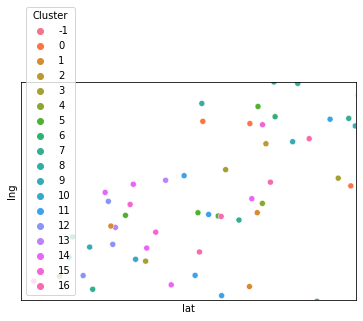

La solution pour le cluster 1 :


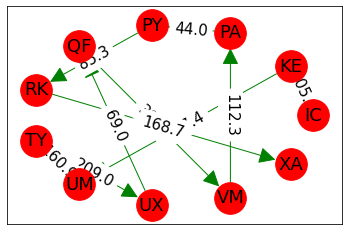

La solution pour le cluster 2 :


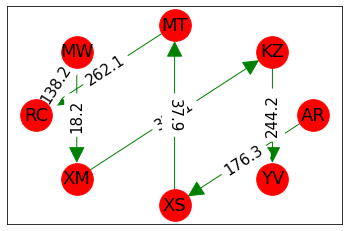

La solution pour le cluster 3 :


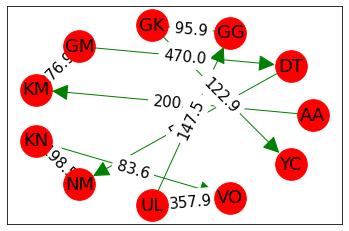

La solution pour le cluster 4 :


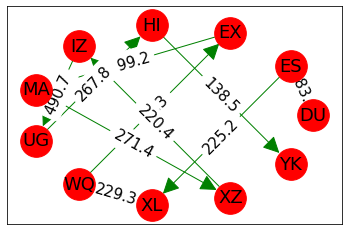

La solution pour le cluster 5 :


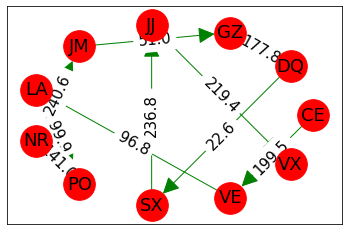

La solution pour le cluster 6 :


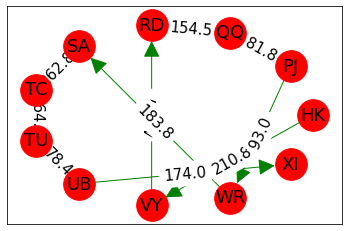

La solution pour le cluster 7 :


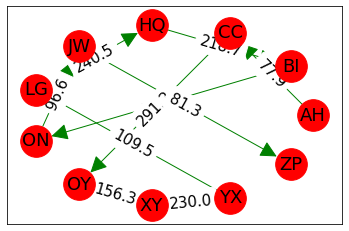

La solution pour le cluster 8 :


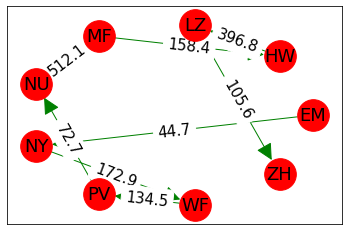

La solution pour le cluster 9 :


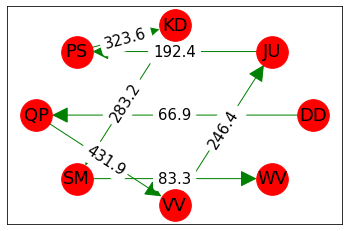

La solution pour le cluster 10 :


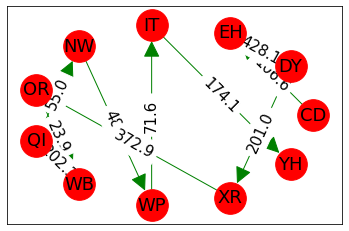

La solution pour le cluster 11 :


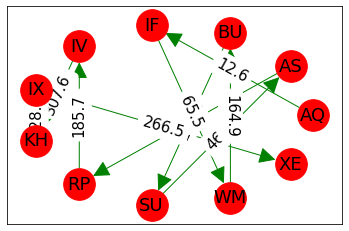

La solution pour le cluster 12 :


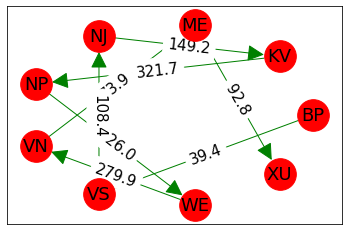

La solution pour le cluster 13 :


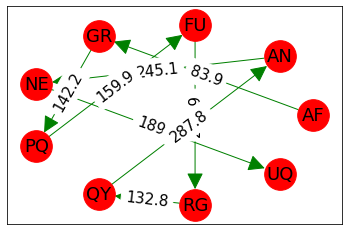

La solution pour le cluster 14 :


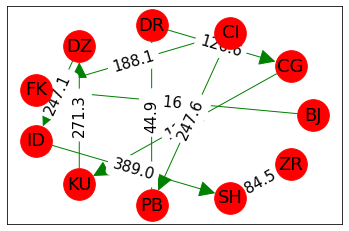

La solution pour le cluster 15 :


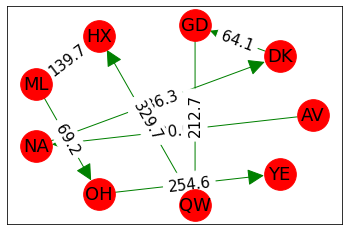

La solution pour le cluster 16 :


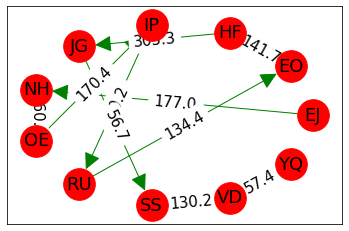

In [9]:
#on test pour la route 20
number=20
origin_time=datetime.strptime(routedf.iloc[number]["date_YYYY_MM_DD"]+" "+"00:00:00",'%Y-%m-%d %H:%M:%S')
route(number)